In [1]:
# import needed libriaries

# ema_workbench components needed
from ema_workbench import ScalarOutcome
from ema_workbench.analysis import parcoords # to plot the parallel coordinates plot

# model functions needed
from problem_formulation import get_model_for_problem_formulation

# other libraries needed 
import pandas as pd # to deal with csv files and manipulate dataframes
import pickle # to read dictionaries
import numpy as np # to run analyses
import matplotlib.pyplot as plt # to plot

## Compute robustness after first optimization and re-eavaluation

To compute the robustness of the policies found via the first optimization, we decide to use the <code>signal-to-noise ratio</code>, which divides the mean of a dataset by its standard deviation in case of maximization or multiplies these two quantities in case of minimization. In our case, for each policy we compute this metric on the values of each outcome (that is on the values of the outcome that the policy produced over all the scenarios). Since our goal is to have these outcomes minimized, ideally the mean of the dataset would low and a low standard deviation is preferred for consitency reasons: therefor the metric would be low.

In [2]:
# define a function to compute the signal-to-noise ratio metric
def s_to_n(data, direction):
    # compute mean and standard deviation of the dataset using numpy library
    mean = np.mean(data)
    std = np.std(data)
    
    # compute the metric
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else: # in case of minimization the formulation of the metric is different
        return mean*std

In [3]:
# import the data from the first re-evaluation
experiments = pd.read_csv("intermediate outputs/step2 - first re-evaluation - experiments description.csv")
experiments = experiments.drop(columns=['Unnamed: 0']) # cleaning

outcomes_file = open("intermediate outputs/step2 - first re-evaluation - outcomes description.pkl", "rb")
outcomes = pickle.load(outcomes_file)

In [4]:
# prepare the model object
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [5]:
# compute the robustness scores
overall_scores = {}

for policy in np.unique(experiments['policy']): # for each of the policy found
    scores = {}
    
    logical = experiments['policy']==policy # find the experiments this policy has been tested against
    
    for outcome in dike_model.outcomes: # for each of the outcomes of interest
        value  = outcomes[outcome.name][logical] # select the outcomes for the policy and the experiments
        sn_ratio = s_to_n(value, outcome.kind) # compute the metric
        scores[outcome.name] = sn_ratio # save the result for this outcome
        
    overall_scores[policy] = scores # save the results for this policy for all the outcomes
    
scores = pd.DataFrame.from_dict(overall_scores).T # create a dataframe out of the results for all the policies
scores.head()

,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,Expected Evacuation Costs,RfR Total Costs,Other.Dikes_Expected Annual Damage,Other.Dikes_Total Dike Investment Costs,Other.Dikes_Expected Number of Deaths
0,0.01766,1.655809e+14,0.000029,0.0,1.122296e+15,0.000817,0.0,0.0,2.840611e+16,3.005173,0.055007
1,0.00000,2.103628e+14,0.000036,0.0,1.130927e+15,0.000835,0.0,0.0,4.246238e+16,0.319022,0.050415
2,0.00000,1.252448e+14,0.000019,0.0,1.126671e+15,0.000841,0.0,0.0,4.632287e+16,0.000000,0.051974
3,0.00000,1.096090e+14,0.000016,0.0,9.950512e+14,0.000735,0.0,0.0,1.894694e+17,0.000000,0.128737
4,0.01766,1.276854e+14,0.000022,0.0,1.139661e+15,0.000836,0.0,0.0,1.299238e+17,0.000000,0.116433


Now that we have the robustness scores, we can display them on <code>Parallel coordinates plots</code>.

First we print the scores for the outcomes that are of main concern for our client, the expected number of deaths.

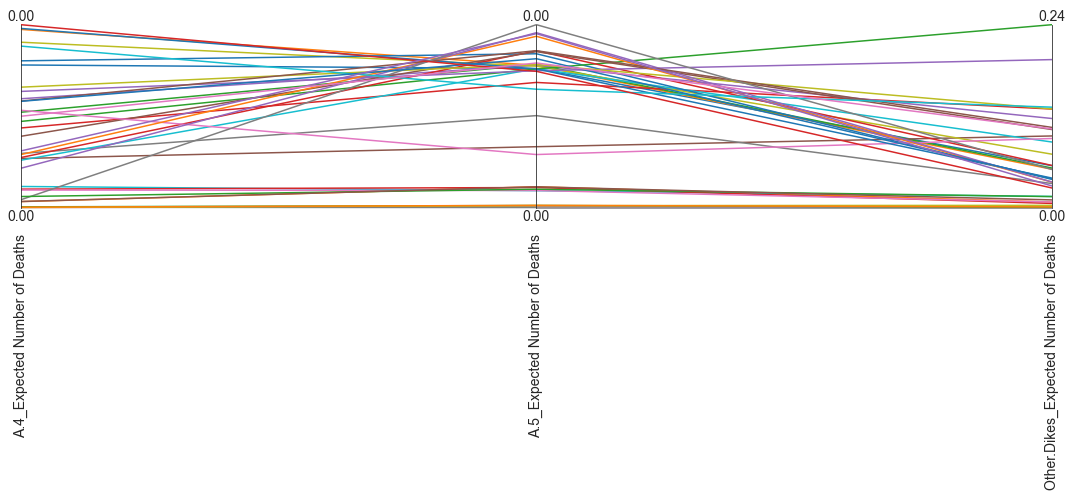

In [9]:
# select the data
data = data = scores.loc[:, [o for o in ['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths', 'Other.Dikes_Expected Number of Deaths']]]

# set up the parallel coordinate plot using the ema_workbench librairy functions
limits = parcoords.get_limits(data)
plt.rcParams["figure.figsize"] = (15,7) # set up the size of the picture
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

# save the figure in a png file and show it
plt.savefig('output pictures/step3 - robustness of re-evaluated policies, only safety.png')
plt.show() # plots

Now we show the robustness values for all of the outcomes.

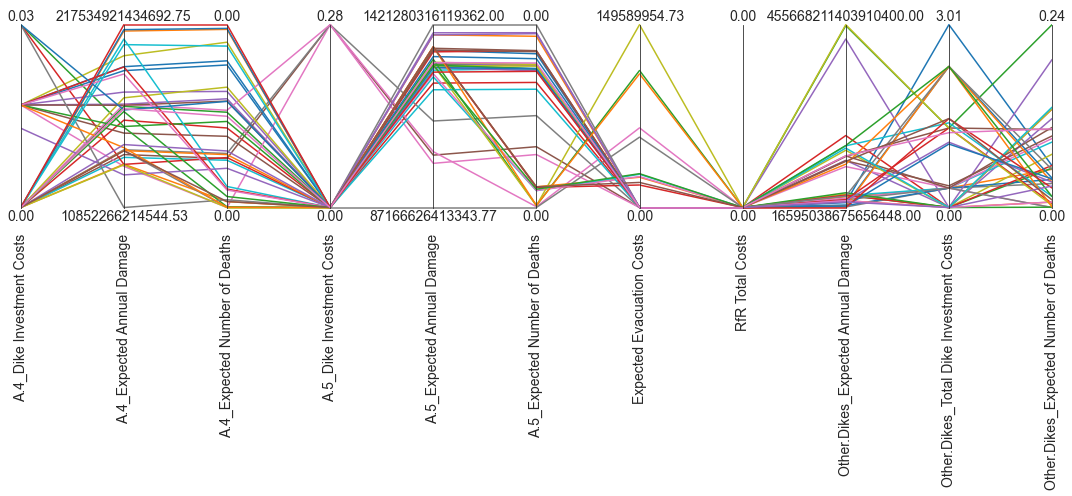

In [10]:
# set up the parallel coordinate plot using the ema_workbench librairy functions
limits = parcoords.get_limits(scores)
plt.rcParams["figure.figsize"] = (15,7) # set up the size of the picture
paraxes = parcoords.ParallelAxes(scores)
paraxes.plot(scores)

# save the figure in a png file and show it
plt.savefig('output pictures/step3 - robustness of re-evaluated policies, all outcomes.png')
plt.show() # plots